# Single Stock Close-EWMA Crossover Strategy

- long when close > EWMA21 (i.e. close crosses above close)
- short when close < EWMA21 (i.e. close crosses below close)

## Import libraries

In [1]:
pip install yfinance

In [2]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats import kurtosis
plt.style.use("seaborn-whitegrid")

## Load stock data

In [3]:
ticker = "AAPL"
aapl_df = yf.download(tickers=ticker, period="max", interval="1d", group_by="ticker", auto_adjust=True)
aapl_df

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Volume
Date,,,,,
1980-12-12,0.100600,0.101037,0.100600,0.100600,469033600
1980-12-15,0.095789,0.095789,0.095352,0.095352,175884800
1980-12-16,0.088790,0.088790,0.088353,0.088353,105728000
1980-12-17,0.090540,0.090977,0.090540,0.090540,86441600
1980-12-18,0.093165,0.093602,0.093165,0.093165,73449600
...,...,...,...,...,...
2021-08-06,146.350006,147.110001,145.630005,146.139999,54067400
2021-08-09,146.199997,146.699997,145.520004,146.089996,48908700
2021-08-10,146.440002,147.710007,145.300003,145.600006,68922200


## Get close prices

In [4]:
aapl_close = aapl_df.copy()
aapl_close = aapl_close.drop(columns=["Open", "High", "Low", "Volume"])
aapl_close = aapl_close.rename(columns={"Close":"AAPL"})
aapl_close

,AAPL
Date,
1980-12-12,0.100600
1980-12-15,0.095352
1980-12-16,0.088353
1980-12-17,0.090540
1980-12-18,0.093165
...,...
2021-08-06,146.139999
2021-08-09,146.089996
2021-08-10,145.600006


## Visualise adjusted close prices

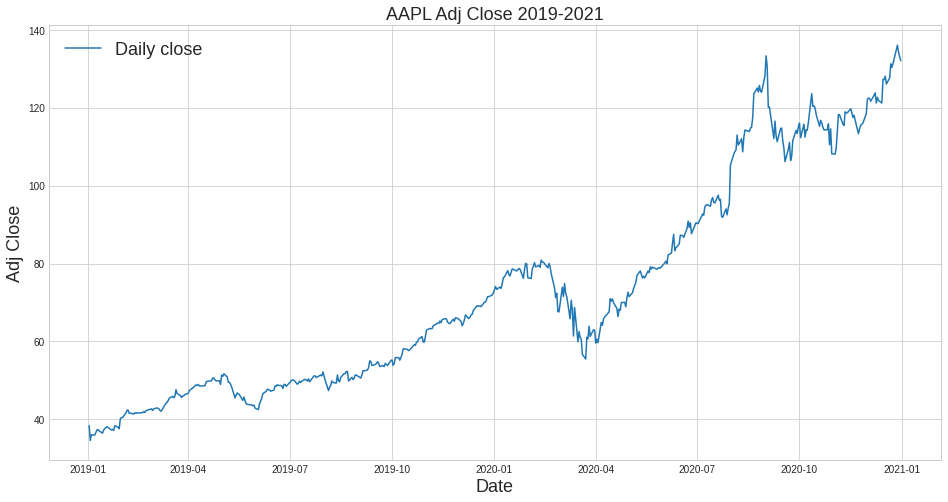

In [5]:
plt.figure(figsize=(16,8))
plt.plot(aapl_close.loc["2019-01-01":"2021-01-01", "AAPL"], label="Daily close")
plt.title("AAPL Adj Close 2019-2021", fontsize=18)
plt.legend(fontsize=18)
plt.xlabel("Date", fontsize=18)
plt.ylabel("Adj Close", fontsize=18)
plt.show()

## Exponentially Weighted Moving Average (EWMA)

In [6]:
def EWMA(df, period):
  return df.ewm(span=period, adjust=False).mean()

In [7]:
aapl_ewma = aapl_close.copy()
aapl_ewma.loc[:,"AAPL"] = EWMA(aapl_ewma, 21)
aapl_ewma

,AAPL
Date,
1980-12-12,0.100600
1980-12-15,0.100123
1980-12-16,0.099053
1980-12-17,0.098279
1980-12-18,0.097814
...,...
2021-08-06,144.768334
2021-08-09,144.888485
2021-08-10,144.953169


## Visualise SMA on top of adjusted close

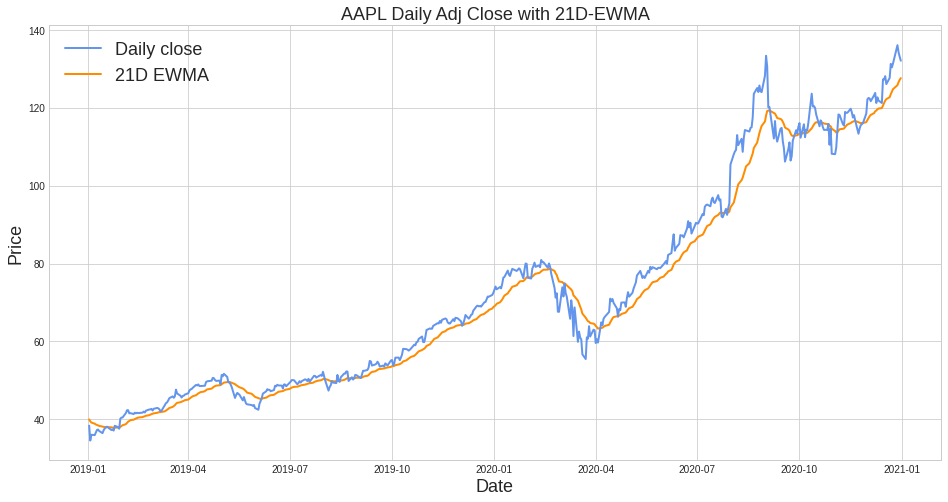

In [8]:
plt.figure(figsize=(16,8))
plt.plot(aapl_close.loc["2019-01-01":"2021-01-01","AAPL"], alpha=1.0, label="Daily close", linewidth=2, color="cornflowerblue", zorder=2)
plt.plot(aapl_ewma.loc["2019-01-01":"2021-01-01","AAPL"], alpha=1.0, label="21D EWMA", linewidth=2, color="darkorange", zorder=1)
plt.title("AAPL Daily Adj Close with 21D-EWMA", fontsize=18)
plt.legend(fontsize=18)
plt.xlabel("Date", fontsize=18)
plt.ylabel("Price", fontsize=18)
plt.show()

## Compute long and short signals

- Long: close > EWMA21
- Short: close < EWMA21

In [9]:
def get_long_short(close, moving_avg):
  # create initial long/short signal dataframe with all zeros
  long_short = (close*0).fillna(0).astype(np.int)
  # create long signals when close > moving avg
  long_signals = (close > moving_avg).astype(np.int)
  # create short signals when close < moving avg
  short_signals = (close < moving_avg).astype(np.int)
  # combine both long and short signals
  long_short = long_short + long_signals - short_signals

  return long_short

In [10]:
# compute signals b/w 2020 and 2021 and cut ewma and close to that timeframe too
aapl_close = aapl_close.loc["2019-01-01":"2021-01-01", :]
aapl_ewma = aapl_ewma.loc["2019-01-01":"2021-01-01", :]
signal = get_long_short(aapl_close, aapl_ewma)
signal

,AAPL
Date,
2019-01-02,-1
2019-01-03,-1
2019-01-04,-1
2019-01-07,-1
2019-01-08,-1
...,...
2020-12-24,1
2020-12-28,1
2020-12-29,1


## Filter signal

Filter out all consecutive-equal signals, so only long/short changes remain.

In [11]:
def filter_signal(signal):

  filtered_signal = signal.copy()
  for ticker in filtered_signal:
    filtered_signal.loc[filtered_signal[ticker].shift(1).eq(filtered_signal[ticker])] = 0
  
  return filtered_signal

In [12]:
filtered_signal = filter_signal(signal)
filtered_signal

,AAPL
Date,
2019-01-02,-1
2019-01-03,0
2019-01-04,0
2019-01-07,0
2019-01-08,0
...,...
2020-12-24,0
2020-12-28,0
2020-12-29,0


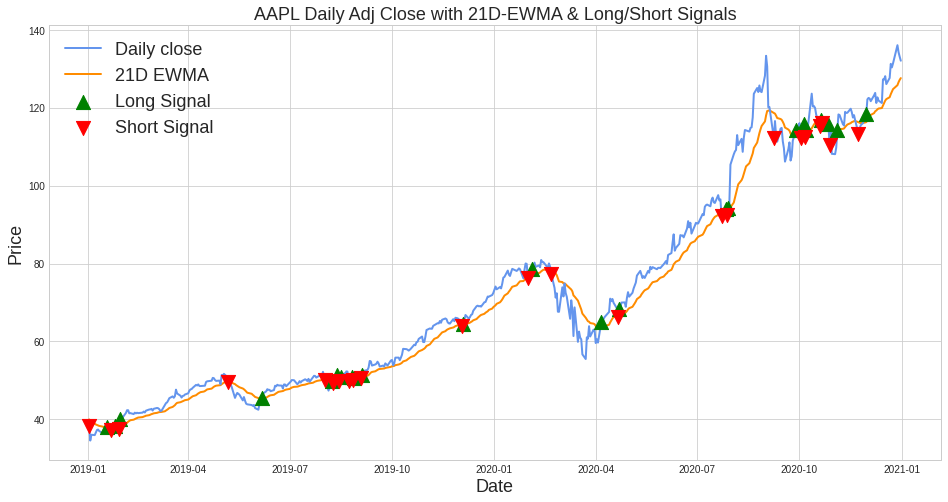

In [13]:
plt.figure(figsize=(16,8))
plt.plot(aapl_close.loc[:,"AAPL"], alpha=1.0, label="Daily close", linewidth=2, color="cornflowerblue", zorder=2)
plt.plot(aapl_ewma.loc[:,"AAPL"], alpha=1.0, label="21D EWMA", linewidth=2, color="darkorange", zorder=1)
plt.scatter(filtered_signal.index, np.where(filtered_signal.loc[:, "AAPL"]==1, aapl_close.loc[:,"AAPL"], np.nan), alpha=1, label="Long Signal", marker="^", color="green", s=200, zorder=3)
plt.scatter(filtered_signal.index, np.where(filtered_signal.loc[:, "AAPL"]==-1, aapl_close.loc[:, "AAPL"], np.nan), alpha=1, label="Short Signal", marker="v", color="red", s=200, zorder=5)
plt.title("AAPL Daily Adj Close with 21D-EWMA & Long/Short Signals", fontsize=18)
plt.legend(fontsize=18)
plt.xlabel("Date", fontsize=18)
plt.ylabel("Price", fontsize=18)
plt.show()

## Signal log returns

For each long/short signal get the price of the next (opposite) signal to compute the returns made in the period between signal changes.

In [14]:
def get_lookahead_returns(close, signal):

  entry_signals = signal.copy()
  entry_signals = entry_signals[entry_signals!=0].dropna(axis=0)

  entry_prices = close.copy()
  entry_prices = entry_prices[signal!=0].dropna(axis=0)

  exit_prices = entry_prices.shift(-1)
  price_returns = exit_prices/entry_prices - 1
  signal_returns = entry_signals * price_returns

  return pd.DataFrame(data={"Entry prices":entry_prices["AAPL"],
                            "Exit prices":exit_prices["AAPL"],
                            "Price returns":price_returns["AAPL"],
                            "Entry signals":entry_signals["AAPL"],
                            "Signal returns":signal_returns["AAPL"]}, index=entry_signals.index)

In [15]:
return_df = get_lookahead_returns(aapl_close, filtered_signal)
return_df.head(50)

,Entry prices,Exit prices,Price returns,Entry signals,Signal returns
Date,,,,,
2019-01-02,38.382229,38.114872,-0.006966,-1.0,0.006966
2019-01-18,38.114872,37.259346,-0.022446,1.0,-0.022446
2019-01-22,37.259346,38.343330,0.029093,-1.0,-0.029093
2019-01-25,38.343330,37.594753,-0.019523,1.0,-0.019523
2019-01-29,37.594753,40.163769,0.068334,-1.0,-0.068334
2019-01-30,40.163769,49.516289,0.232860,1.0,0.232860
2019-05-07,49.516289,45.384624,-0.083441,-1.0,0.083441
2019-06-06,45.384624,49.991215,0.101501,1.0,0.101501
2019-08-02,49.991215,49.846642,-0.002892,-1.0,0.002892


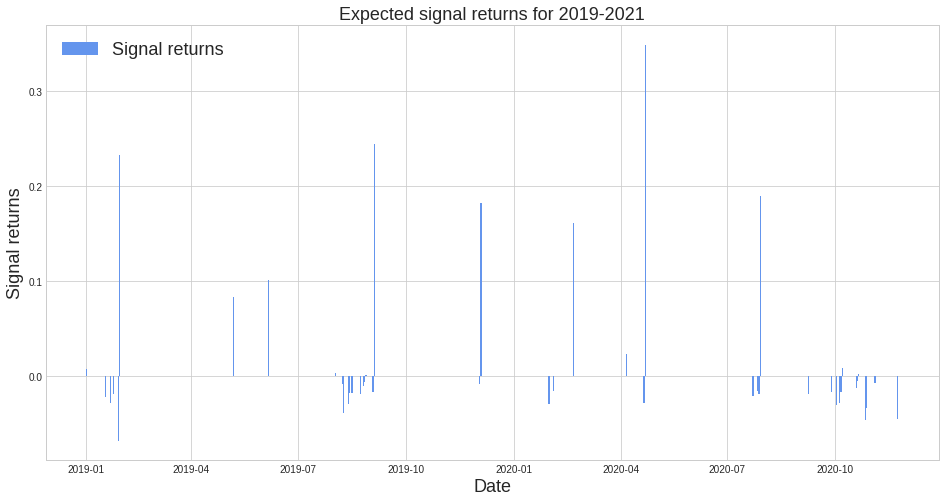

In [16]:
plt.figure(figsize=(16,8))
plt.bar(return_df.index, return_df.loc[:,"Signal returns"], alpha=1.0, label="Signal returns", width=1, color="cornflowerblue", zorder=1)
plt.legend(fontsize=18)
plt.title("Expected signal returns for 2019-2021", fontsize=18)
plt.xlabel("Date", fontsize=18)
plt.ylabel("Signal returns", fontsize=18)
plt.show()

## Show descriptive statistics of return distribution

In [17]:
stats_table = pd.DataFrame(data={"Stats":["Mean", "Median", "Max", "Min", "St. dev.","Skew", "Kurtosis"]})
stats_table.set_index("Stats", inplace=True)

stats_table["{}".format("Signal returns")] = [return_df.loc[:, "Signal returns"].mean(),
                                              return_df.loc[:, "Signal returns"].median(),
                                              return_df.loc[:, "Signal returns"].max(),
                                              return_df.loc[:, "Signal returns"].min(), 
                                              return_df.loc[:, "Signal returns"].std(), 
                                              skew(return_df.loc[:, "Signal returns"][0:-1]), 
                                              kurtosis(return_df.loc[:, "Signal returns"][0:-1], fisher=True)]
stats_table

,Signal returns
Stats,
Mean,0.019421
Median,-0.016428
Max,0.348733
Min,-0.068334
St. dev.,0.089626
Skew,2.122673
Kurtosis,3.689837


## Cumulative returns

In [18]:
def cumulative_signal_returns(signal_returns):

  cumulative_returns = 1 # start with 100%
  for signal_return in signal_returns[:-1]:
    cumulative_returns = cumulative_returns * (1+signal_return)

  return cumulative_returns

In [19]:
signal_cum_ret = cumulative_signal_returns(return_df.loc[:, "Signal returns"])
signal_cum_ret

2.0399106222423193

In [20]:
# confirm function results
signal_cumulative_returns = (return_df.loc[:, "Signal returns"]+1).cumprod()
signal_cumulative_returns

Date
2019-01-02    1.006966
2019-01-18    0.984363
2019-01-22    0.955725
2019-01-25    0.937067
2019-01-29    0.873033
2019-01-30    1.076327
2019-05-07    1.166136
2019-06-06    1.284500
2019-08-02    1.288215
2019-08-08    1.277600
2019-08-09    1.226874
2019-08-13    1.190356
2019-08-14    1.168340
2019-08-16    1.146501
2019-08-23    1.124718
2019-08-26    1.112027
2019-08-27    1.104565
2019-08-28    1.105478
2019-09-03    1.086722
2019-09-04    1.351865
2019-12-03    1.339933
2019-12-04    1.584483
2020-01-31    1.536669
2020-02-04    1.512296
2020-02-21    1.756641
2020-04-06    1.796128
2020-04-21    1.744394
2020-04-22    2.352722
2020-07-23    2.302929
2020-07-27    2.265097
2020-07-28    2.221679
2020-07-29    2.642064
2020-09-08    2.591949
2020-09-28    2.548209
2020-10-02    2.469747
2020-10-05    2.398941
2020-10-06    2.358238
2020-10-07    2.376681
2020-10-19    2.345327
2020-10-20    2.332554
2020-10-21    2.337943
2020-10-27    2.229668
2020-10-28    2.154476
2020-1